# Inital Setup

In [ ]:
%tensorflow_version 1.14
!pip install keras==2.2.5
!pip install simpleitk
!pip install h5py==2.10.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'1.15.2'

In [ ]:
import tensorflow as tf
print(tf.__version__, tf.test.is_gpu_available())

1.15.2 True


# EDA On BraTS18 Dataset

In [ ]:
path = "/content/drive/MyDrive/HGG/"

In [ ]:
files = glob(path+"**/*flair.nii.gz")

len(files)

210

## Convert to Array

In [ ]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


## Visualize Flair Images from BraTS18

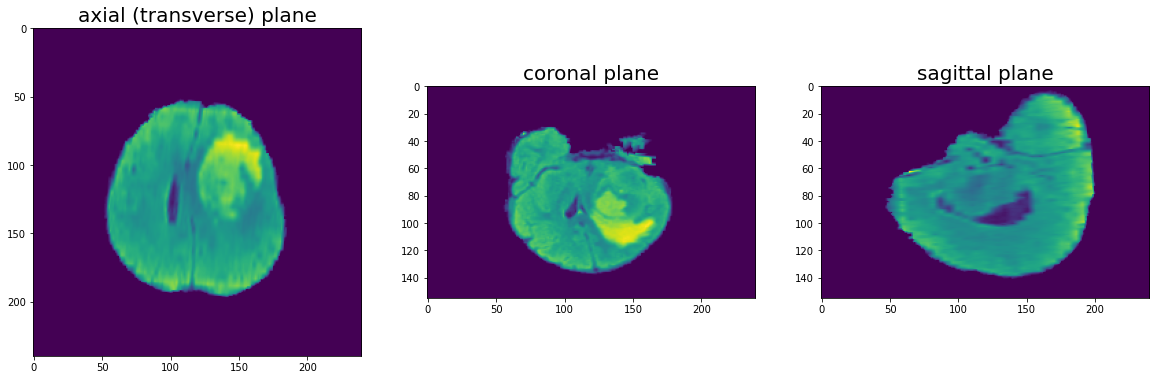

In [ ]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[60,:,:])
plt.title("axial (transverse) plane", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,60,:])
plt.title("coronal plane", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,60])
plt.title("sagittal plane", fontsize=20);

## Visualize Segmented Image

In [ ]:
files[1]

'/content/drive/MyDrive/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii.gz'

In [ ]:
seg_img = io.imread('/content/drive/MyDrive/HGG/Brats18_2013_2_1/Brats18_2013_2_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


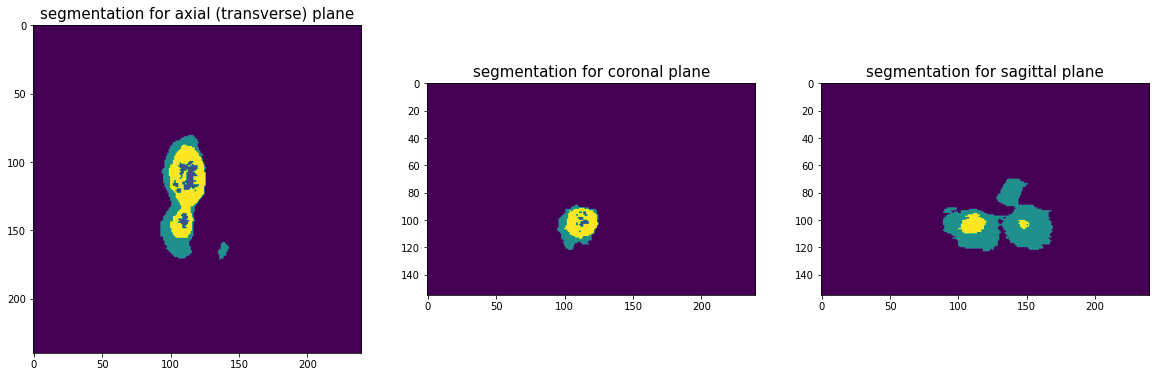

In [ ]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("segmentation for coronal plane", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("segmentation for sagittal plane", fontsize=15);

# Function for Convert Train Data to Numpy Array 

In [ ]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    count = 0
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 130):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
        count += 1
        if(count >=1):
            break
            
    return np.array(img_list,np.float32)

### Looking at the Shape of a Train data image

In [ ]:
first_img.shape

(155, 240, 240)

In [ ]:
exp = first_img[60,:,:]
exp.shape

(240, 240)

In [ ]:
exp = np.expand_dims(exp, axis=0)
exp.shape


(1, 240, 240)

### Applying the Train Data to Numpy Array Function

In [ ]:
train = to_array(path=path, end="**/*flair.nii.gz")

In [ ]:
train.shape

(70, 1, 128, 128)

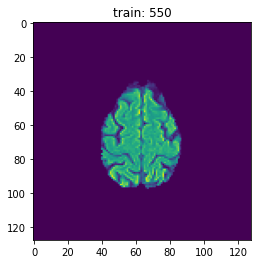

In [ ]:
plt.imshow(train[60].reshape(128,128))
plt.title("train: 550");

In [ ]:
t1ce = to_array(path=path, end='**/*t1ce.nii.gz')

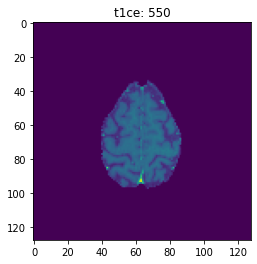

In [ ]:
plt.imshow(t1ce[60].reshape(128,128))
plt.title("t1ce: 550");

## Sample of Segmented Images from Dataset

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [ ]:
seg_img.shape

(155, 240, 240)

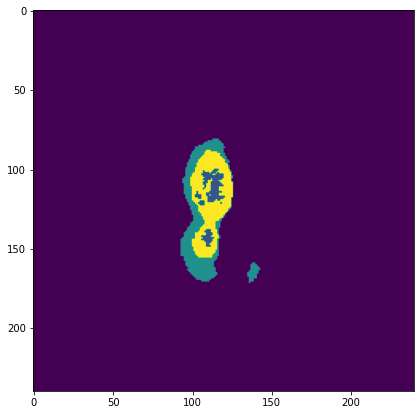

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[60,:,:]);

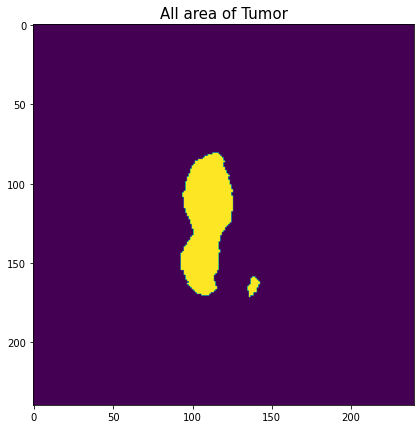

In [ ]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[60,:,:])
plt.title("All area of Tumor", fontsize=15);

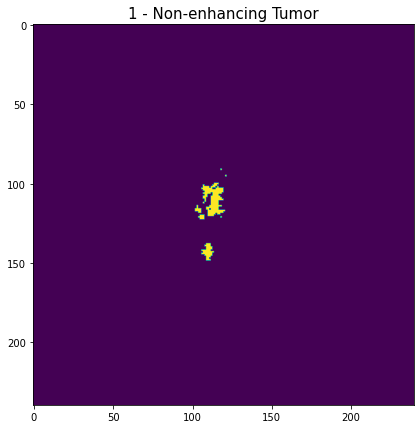

In [ ]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[60,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

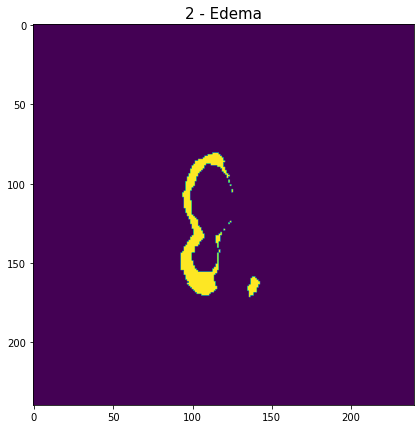

In [ ]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[60,:,:])
plt.title("2 - Edema", fontsize=15);

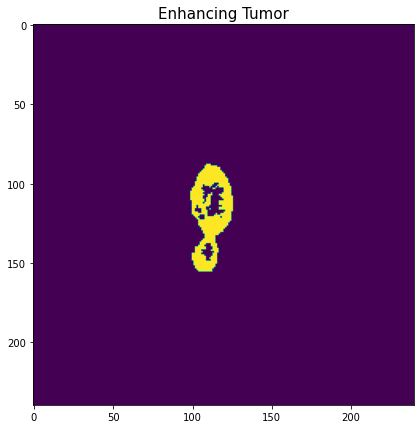

In [ ]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[60,:,:])
plt.title("Enhancing Tumor", fontsize=15);

## Segmented Images from Dataset To Numpy Array (Taking into Account Labels)

In [ ]:
def seg_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    count = 0
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(60, 130):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
        count += 1
        if(count >=1):
            break
            
    return np.array(img_list,np.float32)

In [ ]:
seg_all_tumor = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

seg_non_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=2)

seg_out_edema = seg_to_array(path=path, end="**/*seg.nii.gz", label=3) 

seg_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=4) 

seg_original = seg_to_array(path=path, end="**/*seg.nii.gz", label=0)

In [ ]:
seg_all_tumor.shape

(70, 1, 128, 128)

In [ ]:
seg_non_enhancing.shape

(70, 1, 128, 128)

## EDA on Segmentation Images from Dataset

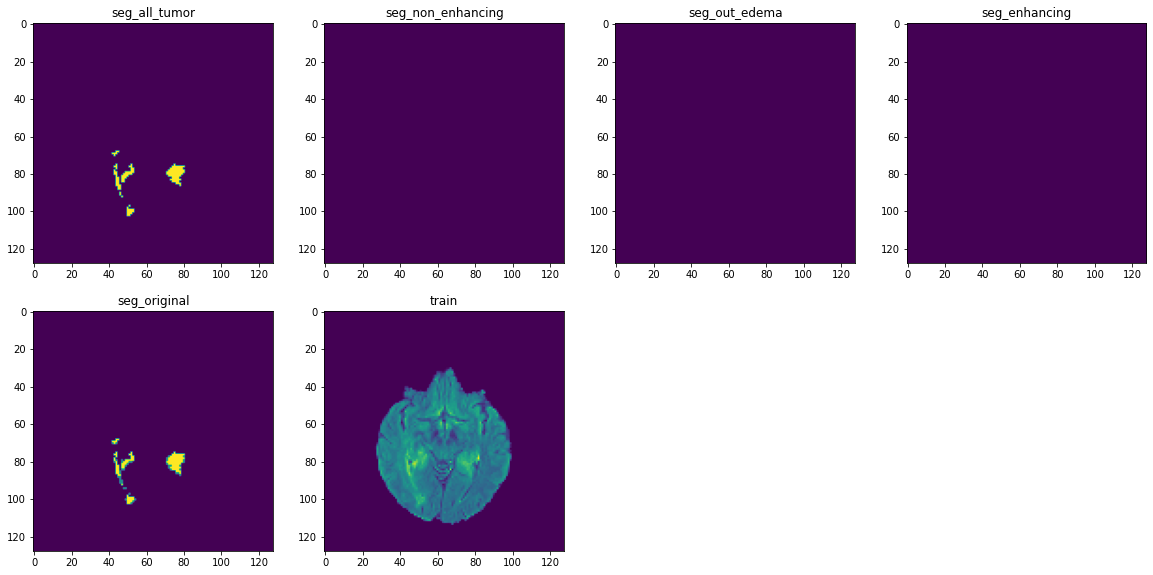

In [ ]:
idx = 1

plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(seg_all_tumor[idx].reshape(128,128))
plt.title("seg_all_tumor")

plt.subplot(3,4,2)
plt.imshow(seg_non_enhancing[idx].reshape(128,128))
plt.title("seg_non_enhancing")

plt.subplot(3,4,3)
plt.imshow(seg_out_edema[idx].reshape(128,128))
plt.title("seg_out_edema")

plt.subplot(3,4,4)
plt.imshow(seg_enhancing[idx].reshape(128,128))
plt.title("seg_enhancing")

plt.subplot(3,4,5)
plt.imshow(seg_original[idx].reshape(128,128))
plt.title("seg_original")

plt.subplot(3,4,6)
plt.imshow(train[idx].reshape(128,128))
plt.title("train");

# Peparing the Train Data and Labels / Segmented Images

In [ ]:
flair = to_array(path=path, end="**/*flair.nii.gz")
t2 = to_array(path=path, end="**/*t2.nii.gz")
seg = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

In [ ]:
flair.shape, t2.shape, seg.shape

((70, 1, 128, 128), (70, 1, 128, 128), (70, 1, 128, 128))

## Merging the Flair and T2 Sequences to a single Numpy Array

In [ ]:
X_train = np.concatenate((flair, t2), axis=1)

In [ ]:
X_train.shape

(70, 2, 128, 128)

In [ ]:
X_train.dtype

dtype('float32')

# Semantic Segmentation Model using Keras and a custom loss function

## Building the Model

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')


def unet():
    
    inputs = Input((2, 128 , 128))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model = unet()

In [ ]:
p

## Training the Model using Tensorflow GPU (Batch size = 32, Epochs = 50) 75-25 Split

In [ ]:
with tf.device('/device:GPU:0'):
  model.fit(X_train, seg, validation_split=0.25, batch_size=32, epochs=50, shuffle=True)



Train on 9450 samples, validate on 3150 samples
Epoch 1/50
9450/9450 [==============================] - 161s 17ms/step - loss: 0.7545 - dice_coef: 0.2455 - val_loss: 0.5431 - val_dice_coef: 0.4569
Epoch 2/50
9450/9450 [==============================] - 139s 15ms/step - loss: 0.5695 - dice_coef: 0.4305 - val_loss: 0.4213 - val_dice_coef: 0.5787
Epoch 3/50
9450/9450 [==============================] - 141s 15ms/step - loss: 0.3769 - dice_coef: 0.6231 - val_loss: 0.3236 - val_dice_coef: 0.6764
Epoch 4/50
9450/9450 [==============================] - 140s 15ms/step - loss: 0.2314 - dice_coef: 0.7686 - val_loss: 0.2612 - val_dice_coef: 0.7388
Epoch 5/50
9450/9450 [==============================] - 141s 15ms/step - loss: 0.1607 - dice_coef: 0.8393 - val_loss: 0.2745 - val_dice_coef: 0.7255
Epoch 6/50
9450/9450 [==============================] - 141s 15ms/step - loss: 0.1262 - dice_coef: 0.8738 - val_loss: 0.2515 - val_dice_coef: 0.7485
Epoch 7/50
9450/9450 [==============================] - 

## Saving the Model for Later Inference

In [ ]:
model.save_weights("/content/drive/MyDrive/subset_model.h5")

# Inference

In [ ]:
model.load_weights("/content/drive/MyDrive/subset_model.h5")

## Brain Tumor Segmentation predicition of MRI scan using .NII scans

In [ ]:
plt.imshow(X_train[330][0]);

IndexError: ignored

In [ ]:
plt.imshow(seg[330][0]);

IndexError: ignored

In [ ]:
expand_img = np.expand_dims(X_train[330], axis=0)
print(expand_img.shape)
pred = model.predict(expand_img)

(1, 2, 128, 128)


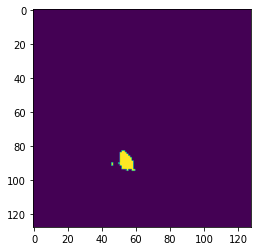

In [ ]:
plt.imshow(pred[0][0] );

## Comparing the Predicition vs A pre segmented Image from Dataset for a MRI Scan

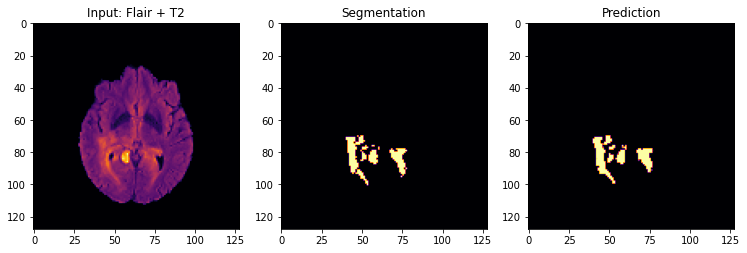

In [ ]:
  x = 10

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


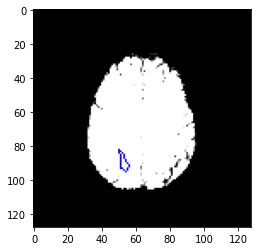

In [ ]:
import numpy as np
import cv2
segmented = pred[0][0]
segmented =  segmented.astype(np.uint8)
main = cv2.cvtColor(X_train[x][0],cv2.COLOR_GRAY2RGB)
RGBforLabel = { 1:(0,0,255), 2:(0,255,255) }
contours,_ = cv2.findContours(segmented,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

for i,c in enumerate(contours):
    # Find mean colour inside this contour by doing a masked mean
    mask = np.zeros(segmented.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    # DEBUG: cv2.imwrite(f"mask-{i}.png",mask)
    mean,_,_,_ = cv2.mean(segmented, mask=mask)
    # DEBUG: print(f"i: {i}, mean: {mean}")

    # Get appropriate colour for this label
    label = 2 if mean > 1.0 else 1
    colour = RGBforLabel.get(label)
    # DEBUG: print(f"Colour: {colour}")

    # Outline contour in that colour on main image, line thickness=1
    cv2.drawContours(main,[c],-1,colour,1)

# Show result
plt.imshow(main, cmap="inferno");



---



**End of Segmentation Code ** 

---





